In [2]:
import torch
import os
from natsort import natsorted
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

In [3]:

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '2'


In [4]:
import numpy as np
# # Load the data from the NPZ file
data = np.load('data.npz')

# Assign X and Y from the loaded data
X = data['X']
Y = data['Y'].astype(np.int32)

# Optionally, check shapes of the loaded arrays
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# Assuming Y is your numpy array
print("Summary Statistics of Y:")
print("Min:", np.min(Y))
print("Max:", np.max(Y))
print("Mean:", np.mean(Y))
print("Median:", np.median(Y))
print("Standard Deviation:", np.std(Y))

# For classification tasks, it might also be useful to see the distribution of classes:
if np.issubdtype(Y.dtype, np.integer):  # Check if Y contains integer (class labels typically are integers)
    print("Class Counts:")
    unique, counts = np.unique(Y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} instances")

Shape of X: (73080, 32, 250)
Shape of Y: (73080,)
Summary Statistics of Y:
Min: 1
Max: 28
Mean: 14.5
Median: 14.5
Standard Deviation: 8.077747210701755
Class Counts:
Class 1: 2610 instances
Class 2: 2610 instances
Class 3: 2610 instances
Class 4: 2610 instances
Class 5: 2610 instances
Class 6: 2610 instances
Class 7: 2610 instances
Class 8: 2610 instances
Class 9: 2610 instances
Class 10: 2610 instances
Class 11: 2610 instances
Class 12: 2610 instances
Class 13: 2610 instances
Class 14: 2610 instances
Class 15: 2610 instances
Class 16: 2610 instances
Class 17: 2610 instances
Class 18: 2610 instances
Class 19: 2610 instances
Class 20: 2610 instances
Class 21: 2610 instances
Class 22: 2610 instances
Class 23: 2610 instances
Class 24: 2610 instances
Class 25: 2610 instances
Class 26: 2610 instances
Class 27: 2610 instances
Class 28: 2610 instances


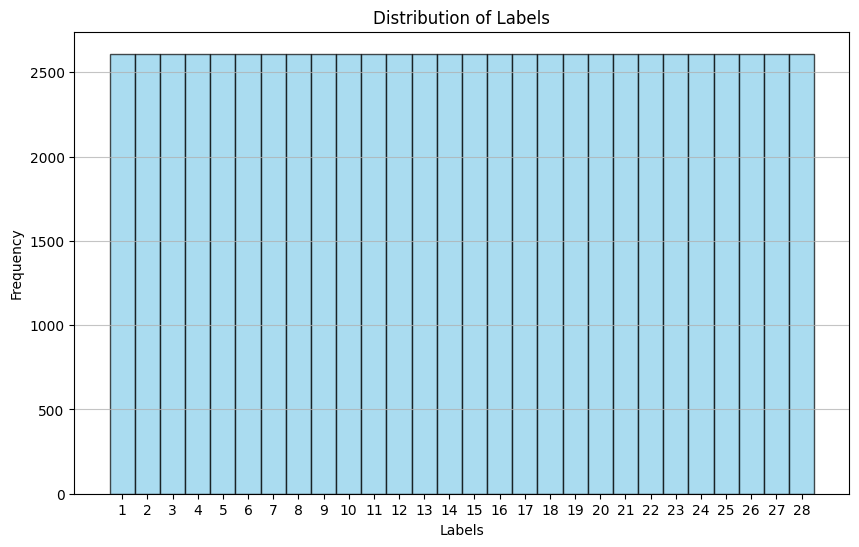

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming Y contains categorical labels from 0 to 8
plt.figure(figsize=(10, 6))
plt.hist(Y, bins=np.arange(min(Y), max(Y)+2) - 0.5, ec='black', alpha=0.7, color='skyblue')
plt.xticks(np.arange(min(Y), max(Y)+1))
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [9]:
import numpy as np

# Assuming Y is your numpy array containing labels
label_map = {
    1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2,
    10: 3, 11: 3, 12: 3, 13: 4, 14: 4, 15: 4, 16: 6, 17: 5,
    18: 5, 19: 5, 20: 6, 21: 6, 22: 6, 23: 7, 24: 7, 25: 7,
    26: 8, 27: 8, 28: 8
}

# Find the maximum label to create a sufficiently large mapping array
max_label = max(label_map.keys())

# Create an array that will hold the new labels
# Initialize it with zeros or another default value that indicates unmapped labels if there are any
new_labels = np.zeros(max_label + 1, dtype=int)  # plus 1 because NumPy arrays are 0-indexed

# Fill in the new_labels array with mapped values
for key, value in label_map.items():
    new_labels[key] = value

# Remap Y using the new_labels array
# Here, Y values must be within the range of label_map keys; otherwise, you need to handle potential out-of-bound indices
Y= new_labels[Y]

# If you want to check or display the remapped array

print("Remapped Y:")
print(Y)


Remapped Y:
[0 0 0 ... 8 8 8]


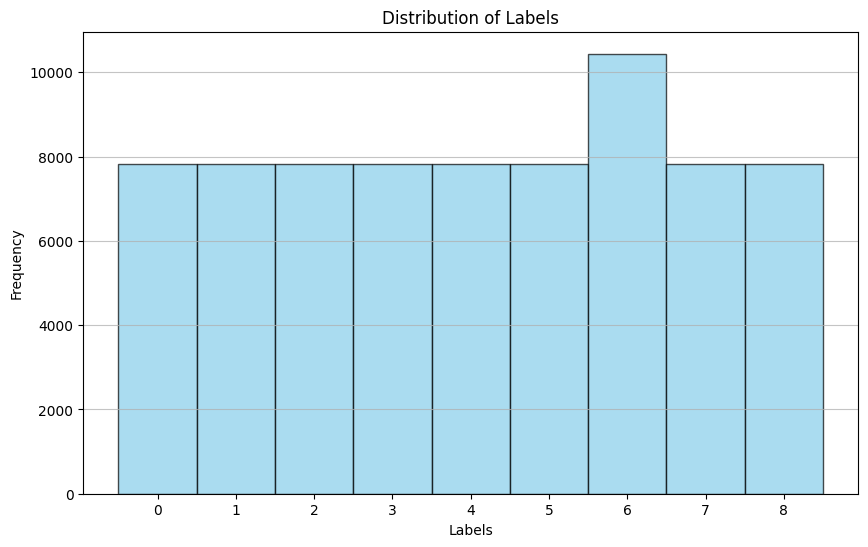

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming Y contains categorical labels from 0 to 8
plt.figure(figsize=(10, 6))
plt.hist(Y, bins=np.arange(min(Y), max(Y)+2) - 0.5, ec='black', alpha=0.7, color='skyblue')
plt.xticks(np.arange(min(Y), max(Y)+1))
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms


In [6]:
class SoundCNN(nn.Module):
    def __init__(self):
        super(SoundCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 31, 512)  # Corrected dimension
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # Assuming 10 different classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
# Reshape data to include channel dimension (1, 32, 250)
X = X.reshape(X.shape[0], 1, 32, 250)

Y = Y.astype(np.int64)


# Convert to torch tensors
tensor_X = torch.Tensor(X)  # transform to torch tensor
tensor_Y = torch.Tensor(Y)

# Create your dataloader
my_dataset = TensorDataset(tensor_X, tensor_Y)
train_loader = DataLoader(my_dataset, batch_size=64, shuffle=True)


In [8]:
model = SoundCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
from torch.utils.data import random_split

# Assuming tensor_X and tensor_Y are already defined
dataset = TensorDataset(tensor_X, tensor_Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [10]:
def validation_accuracy(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()  # Set the model back to train mode
    return 100 * correct / total


In [11]:
tensor_X = torch.Tensor(X)  # Assuming X is your input data.
tensor_Y = torch.Tensor(Y).long()  # Convert labels to long

# Create dataset
my_dataset = TensorDataset(tensor_X, tensor_Y)
train_size = int(0.8 * len(my_dataset))
val_size = len(my_dataset) - train_size

train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [13]:
import os

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path):
    model.train()
    best_accuracy = 0.0  # To track the best model

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = validation_accuracy(model, val_loader)
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Validation Accuracy: {val_acc}%')
        
        # Save the best model if the current model is better
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                'accuracy': val_acc
            }, save_path)
            print(f'Saved better model at epoch {epoch+1} with validation accuracy: {val_acc}%.')

# Define model, criterion, optimizer, and file path for saving the model
model = SoundCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_path = './saveModel.pth'  # Modify path as needed

# Call training function
train_model(model, train_loader, val_loader, criterion, optimizer, 5, save_path)


Epoch 1, Loss: 2.2036166320222734, Validation Accuracy: 20.997536945812808%
Saved better model at epoch 1 with validation accuracy: 20.997536945812808%.
Epoch 2, Loss: 2.0586286523670805, Validation Accuracy: 27.68199233716475%
Saved better model at epoch 2 with validation accuracy: 27.68199233716475%.
Epoch 3, Loss: 1.6360833822246192, Validation Accuracy: 53.99562123700055%
Saved better model at epoch 3 with validation accuracy: 53.99562123700055%.
Epoch 4, Loss: 0.9584037156804125, Validation Accuracy: 72.45484400656814%
Saved better model at epoch 4 with validation accuracy: 72.45484400656814%.
Epoch 5, Loss: 0.5507790184614434, Validation Accuracy: 81.1576354679803%
Saved better model at epoch 5 with validation accuracy: 81.1576354679803%.


In [14]:
test_data = pd.read_excel('/home/project/new/Test.xlsx')

In [15]:
import torch

In [16]:
import numpy as np
import pandas as pd
import torch

# Assuming `test_data` is already loaded and is a Pandas DataFrame
all_test_blocks = []
block_height = 32
num_columns_in_test = 750  # Columns per test block

# Iterate over the dataset in chunks of 32 rows
for start_row in range(0, test_data.shape[0], block_height):
    if start_row + block_height > test_data.shape[0]:
        continue  # Skip incomplete blocks
    chunk = test_data.iloc[start_row:start_row + block_height]

    # Split each 750-column block into three 250-column blocks
    for i in range(3):  # Since 750/250 = 3
        start_col = i * 250
        end_col = start_col + 250
        block = chunk.iloc[:, start_col:end_col]
        all_test_blocks.append(block.values.reshape(1, block_height, 250))  # Adding channel dimension

# Convert blocks to PyTorch tensors
X_test_blocks = torch.tensor(all_test_blocks, dtype=torch.float)


/tmp/ipykernel_1344192/2964036573.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X_test_blocks = torch.tensor(all_test_blocks, dtype=torch.float)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Assuming the model is already defined as `SoundCNN`
model = SoundCNN()
model.load_state_dict(torch.load('/home/project/new/saveModel.pth', map_location=device))
# model.load_state_dict(torch.load('/home/project/new/SoundCNN_model.pth')['model_state_dict'])

# Transfer model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode


In [ ]:
X_test_blocks = X_test_blocks.to(device)  # Move the test data to the same device as the model
with torch.no_grad():  # Ensure no gradients are computed during inference
    predictions = model(X_test_blocks)
    predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()  # Move predictions back to CPU and convert to numpy


In [ ]:
import pandas as pd

# `predicted_classes` is the numpy array containing the class indices predicted by the model
predictions_df = pd.DataFrame(predicted_classes, columns=['PredictedClass'])


In [ ]:
# Specify the path and name of the CSV file
csv_file_path = './predictions.csv'

# Save the DataFrame to a CSV file without the index column
predictions_df.to_csv(csv_file_path, index=False)


In [ ]:
label_map = {
    0: "Tiger",
    1: "Snake",
    2: "Wolf",
    3: "Bear",
    4: "Rabbit",
    5: "Monkey",
    6: "Eagle",
    7: "Dolphin",
    8: "Koala"
}



In [ ]:
import pandas as pd

# Assuming `predicted_classes` is already available as a numpy array
predictions_df = pd.DataFrame(predicted_classes, columns=['PredictedClass'])

# Replace numeric labels with animal names using the mapping
predictions_df['PredictedClass'] = predictions_df['PredictedClass'].replace(label_map)


In [ ]:
# Specify the path and name of the CSV file
csv_file_path = './animal_predictions.csv'

# Save the DataFrame to a CSV file without the index column
predictions_df.to_csv(csv_file_path, index=False)


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import random

# Load predictions
predictions_df = pd.read_csv('./animal_predictions.csv')

# Function to determine the majority or random in case of a tie
def majority_or_random(labels):
    count = Counter(labels)
    max_freq = max(count.values())
    candidates = [label for label, freq in count.items() if freq == max_freq]
    return random.choice(candidates)

# Group predictions in groups of 3 and apply the function
grouped_labels = []
for i in range(0, len(predictions_df), 3):
    labels = predictions_df['PredictedClass'][i:i+3].tolist()
    if len(labels) == 3:  # Ensure it's a full group of 3
        grouped_label = majority_or_random(labels)
        grouped_labels.append(grouped_label)

# Create new DataFrame
final_predictions_df = pd.DataFrame(grouped_labels, columns=['MajorityVotedClass'])


In [ ]:
# Save the DataFrame to a CSV file
final_csv_file_path = './final_animal_predictions.csv'
final_predictions_df.to_csv(final_csv_file_path, index=False)


In [ ]:
import pandas as pd

# Load the CSV file
file_path = './final_animal_predictions.csv'
predictions_df = pd.read_csv(file_path)


In [ ]:
# Generate the 'ID' column
predictions_df['ID'] = ['id_' + str(index + 1) for index in predictions_df.index]


In [ ]:
# Reorder columns to make 'ID' the first column
column_order = ['ID', 'MajorityVotedClass']
predictions_df = predictions_df[column_order]


In [ ]:
# Save the updated DataFrame to a new CSV file
updated_csv_file_path = './updated_final_animal_predictions.csv'
predictions_df.to_csv(updated_csv_file_path, index=False)
